# 04 - RAG Pipeline for Explainable Fraud Detection

End-to-end inference pipeline combining:
1. GNN model predictions
2. FAISS-based case retrieval
3. In-Context Learning (ICL) prompt generation
4. LLM integration for explainable analysis

**Objectives:**
- Load trained model and case memory
- Build and test inference pipeline
- Generate ICL prompts from retrieved cases
- Demonstrate full analysis workflow

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check device
device = 'cpu'  # Using CPU for compatibility
print(f"Device: {device}")
print("Imports complete!")

Device: cpu
Imports complete!


## 2. Load All Components

In [2]:
# Load the graph data
from src.data.graph_builder import GraphBuilder

builder = GraphBuilder('../data/elliptic_bitcoin_dataset')
data = builder.build()

print(f"Graph loaded:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Features: {data.num_node_features}")

Loading Elliptic dataset...
  Features: 203,769 nodes, 167 columns
  Labels: 203,769 entries
  Edges: 234,355 directed edges
  Node mapping: 203,769 unique nodes
  Normalizing features...
  Features shape: (203769, 166)
  Time steps: 1 to 49 (49 unique)
  Label distribution:
    unknown: 157,205 (77.15%)
    licit: 42,019 (20.62%)
    illicit: 4,545 (2.23%)
  Edge index shape: (2, 234355)

Temporal splits:
  Train: 34 time steps, 136,265 nodes (29,894 labeled)
  Val:   7 time steps, 30,680 nodes (7,829 labeled)
  Test:  8 time steps, 36,824 nodes (8,841 labeled)

Class weights: licit=0.5541, illicit=5.1226

PyG Data Object Created
Nodes: 203,769
Edges: 234,355
Features: 166
Train nodes: 29,894
Val nodes: 7,829
Test nodes: 8,841
Graph loaded:
  Nodes: 203,769
  Edges: 234,355
  Features: 166


In [3]:
# Load trained GraphSAGE model
from src.models.graphsage import GraphSAGEModel

model = GraphSAGEModel(
    num_features=data.num_node_features,
    num_classes=2,
    hidden_dims=[256, 128],
    embedding_dim=64,
    dropout=0.3
)

# Load checkpoint
checkpoint = torch.load('../baseline/checkpoints/graphsage_baseline.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded!")
print(f"  Test F1: {checkpoint['metrics']['test_f1']:.4f}")
print(f"  Test AUC: {checkpoint['metrics']['test_auc']:.4f}")

Model loaded!
  Test F1: 0.4102
  Test AUC: 0.8311


In [4]:
# Load case memory and FAISS index
from src.memory.case_store import CaseMemory
from src.retrieval.faiss_index import FAISSIndex

case_memory = CaseMemory.load('../case_memory')
faiss_index = FAISSIndex(embedding_dim=64)
faiss_index.load('../case_memory/faiss.index')

print(f"Case memory: {len(case_memory.cases)} cases")
print(f"FAISS index: {faiss_index.num_vectors} vectors")

Loaded 1000 cases from ../case_memory
Loaded FAISS index from ../case_memory/faiss.index: 1000 vectors
Case memory: 1000 cases
FAISS index: 1000 vectors


## 3. Initialize Inference Pipeline

In [5]:
from src.pipeline.inference import InferencePipeline

pipeline = InferencePipeline(
    model=model,
    data=data,
    case_memory=case_memory,
    faiss_index=faiss_index,
    device=device
)

print("Inference pipeline initialized!")

Inference pipeline initialized!


## 4. Single Transaction Analysis

Let's analyze a suspicious transaction step by step.

In [6]:
# Find a high-risk transaction
with torch.no_grad():
    logits, embeddings = model(data.x, data.edge_index)
    fraud_scores = torch.softmax(logits, dim=1)[:, 1].numpy()

# Get high-risk but unlabeled transactions
labels = data.y.numpy()
unlabeled_mask = labels == -1
high_risk_unlabeled = np.where(unlabeled_mask & (fraud_scores > 0.7))[0]

print(f"Found {len(high_risk_unlabeled)} high-risk unlabeled transactions")
print(f"\nSample high-risk transactions (fraud score > 0.7):")
for idx in high_risk_unlabeled[:5]:
    print(f"  Node {idx}: fraud_score = {fraud_scores[idx]:.4f}")

Found 23899 high-risk unlabeled transactions

Sample high-risk transactions (fraud score > 0.7):
  Node 84: fraud_score = 0.9782
  Node 115: fraud_score = 0.9922
  Node 190: fraud_score = 0.8399
  Node 232: fraud_score = 0.8132
  Node 243: fraud_score = 0.9493


In [7]:
# Analyze a suspicious transaction (without GNNExplainer for speed)
test_node = high_risk_unlabeled[0] if len(high_risk_unlabeled) > 0 else 12345

result = pipeline.analyze(
    node_idx=test_node,
    k_cases=5,
    generate_explanation=False,  # Skip for speed
    generate_prompt=True
)

print("Analysis Result:")
print(f"  Node: {result['prediction']['node_idx']}")
print(f"  Fraud Score: {result['prediction']['fraud_score']:.4f}")
print(f"  Predicted: {result['prediction']['predicted_label']}")
print(f"  True Label: {result['prediction']['true_label']}")
print(f"\nSimilar Cases Retrieved: {len(result['similar_cases'])}")

Analysis Result:
  Node: 84
  Fraud Score: 0.9782
  Predicted: illicit
  True Label: unknown

Similar Cases Retrieved: 5


In [8]:
# View retrieved similar cases
print("Similar Historical Cases:")
print("=" * 60)
for i, case_data in enumerate(result['similar_cases'], 1):
    case = case_data['case']
    print(f"\n{i}. Case {case.case_id}")
    print(f"   Similarity: {case_data['similarity']:.4f}")
    print(f"   Fraud Score: {case.fraud_score:.4f}")
    print(f"   True Label: {case.true_label}")
    print(f"   Prediction: {case.predicted_label}")

Similar Historical Cases:

1. Case 20
   Similarity: 0.4569
   Fraud Score: 0.9583
   True Label: illicit
   Prediction: illicit

2. Case 132
   Similarity: 0.4365
   Fraud Score: 0.9704
   True Label: illicit
   Prediction: illicit

3. Case 36
   Similarity: 0.3943
   Fraud Score: 0.9709
   True Label: illicit
   Prediction: illicit

4. Case 80
   Similarity: 0.3803
   Fraud Score: 0.9926
   True Label: illicit
   Prediction: illicit

5. Case 46
   Similarity: 0.3644
   Fraud Score: 0.9796
   True Label: illicit
   Prediction: illicit


In [9]:
# View GNNExplainer explanations for similar cases
print("GNNExplainer Insights for Similar Cases:")
print("=" * 60)
for i, case_data in enumerate(result['similar_cases'], 1):
    case = case_data['case']
    explanation = case.explanation
    print(f"\n{i}. Case {case.case_id} (Node {case.node_idx})")
    print(f"   Method: {explanation.get('method', 'unknown')}")
    if 'top_features' in explanation:
        print(f"   Top Features: {explanation['top_features'][:5]}")
        if 'feature_importance' in explanation:
            importances = [f"{x:.3f}" for x in explanation['feature_importance'][:5]]
            print(f"   Importances:  {importances}")
    if 'edge_mask_mean' in explanation:
        print(f"   Edge Mask Mean: {explanation['edge_mask_mean']:.4f}")

GNNExplainer Insights for Similar Cases:

1. Case 20 (Node 140681)
   Method: gnn_explainer
   Top Features: [142, 154, 97, 52, 81]
   Importances:  ['0.635', '0.626', '0.624', '0.622', '0.615']
   Edge Mask Mean: 0.0000

2. Case 132 (Node 89977)
   Method: feature_magnitude
   Top Features: [113, 115, 135, 134, 112]
   Importances:  ['-1.267', '-1.230', '-1.160', '-1.160', '-1.096']

3. Case 36 (Node 138429)
   Method: gnn_explainer
   Top Features: [139, 91, 112, 164, 90]
   Importances:  ['0.659', '0.624', '0.617', '0.616', '0.615']
   Edge Mask Mean: 0.0000

4. Case 80 (Node 166606)
   Method: feature_magnitude
   Top Features: [148, 3, 151, 103, 101]
   Importances:  ['1.746', '1.574', '1.357', '1.133', '1.132']

5. Case 46 (Node 130390)
   Method: gnn_explainer
   Top Features: [144, 157, 156, 138, 91]
   Importances:  ['0.659', '0.630', '0.617', '0.617', '0.616']
   Edge Mask Mean: 0.0000


## 5. ICL Prompt Generation

Generate the In-Context Learning prompt for LLM analysis.

In [10]:
# Display the generated prompt
print("Generated ICL Prompt:")
print("=" * 80)
if 'prompt' in result:
    print(result['prompt'][:3000])  # First 3000 chars
    if len(result['prompt']) > 3000:
        print(f"\n... [truncated, total length: {len(result['prompt'])} chars]")
else:
    print("Prompt not generated")

Generated ICL Prompt:
# AML Transaction Analyst

You are an expert Anti-Money Laundering (AML) analyst specializing in cryptocurrency 
transaction analysis. Your role is to:

1. **Analyze** suspicious Bitcoin transactions flagged by our ML system
2. **Compare** with historical cases to identify patterns
3. **Assess** the likelihood of illicit activity
4. **Recommend** appropriate actions

## Your Expertise:
- Deep knowledge of money laundering typologies (layering, structuring, mixing)
- Understanding of Bitcoin transaction patterns
- Experience with regulatory requirements (BSA/AML, FATF guidelines)
- Pattern recognition across historical fraud cases

## Important Guidelines:
- Base your analysis on the provided data and similar cases
- Provide clear reasoning for your assessment
- Consider both false positive and false negative risks
- Be specific about which patterns inform your decision

## Current Transaction Analysis

**Transaction ID:** #84
**Fraud Score:** 97.8%
**Risk Level:**

In [11]:
# Build prompts with GNNExplainer insights
from src.prompts.icl_constructor import ICLPromptBuilder, TransactionContext

builder = ICLPromptBuilder(max_cases=3)

# Build explanation narrative from similar cases
explanation_lines = []
for case_data in result['similar_cases'][:3]:
    case = case_data['case']
    exp = case.explanation
    if exp.get('method') == 'gnn_explainer':
        explanation_lines.append(
            f"Case {case.case_id}: GNNExplainer identified features {exp['top_features'][:3]} as most important"
        )

explanation_narrative = " | ".join(explanation_lines) if explanation_lines else "Feature magnitude analysis used"

# Create transaction context with explanation
tx_context = TransactionContext(
    node_idx=test_node,
    fraud_score=result['prediction']['fraud_score'],
    predicted_label=result['prediction']['predicted_label'],
    embedding=result['embedding'].tolist(),
    top_features=[],
    feature_summary="Transaction flagged by ML model with high confidence",
    num_neighbors=10,
    in_degree=5,
    out_degree=5,
    subgraph_summary="Connected to 10 transactions in 2-hop neighborhood",
    explanation_narrative=explanation_narrative
)

# Generate risk-only prompt
risk_prompt = builder.build_prompt(tx_context, result['similar_cases'], task='risk_only')
print(f"Risk-only prompt length: {len(risk_prompt)} chars")

# Generate recommendation prompt  
rec_prompt = builder.build_prompt(tx_context, result['similar_cases'], task='recommendation_only')
print(f"Recommendation prompt length: {len(rec_prompt)} chars")

# Show explanation narrative
print(f"\nExplanation Narrative (from GNNExplainer):")
print(f"  {explanation_narrative}")

Risk-only prompt length: 1818 chars
Recommendation prompt length: 1862 chars

Explanation Narrative (from GNNExplainer):
  Case 20: GNNExplainer identified features [142, 154, 97] as most important | Case 36: GNNExplainer identified features [139, 91, 112] as most important


In [12]:
# View the risk-only prompt (shorter)
print("Risk Assessment Prompt:")
print("=" * 80)
print(risk_prompt)

Risk Assessment Prompt:
# AML Transaction Analyst

You are an expert Anti-Money Laundering (AML) analyst specializing in cryptocurrency 
transaction analysis. Your role is to:

1. **Analyze** suspicious Bitcoin transactions flagged by our ML system
2. **Compare** with historical cases to identify patterns
3. **Assess** the likelihood of illicit activity
4. **Recommend** appropriate actions

## Your Expertise:
- Deep knowledge of money laundering typologies (layering, structuring, mixing)
- Understanding of Bitcoin transaction patterns
- Experience with regulatory requirements (BSA/AML, FATF guidelines)
- Pattern recognition across historical fraud cases

## Important Guidelines:
- Base your analysis on the provided data and similar cases
- Provide clear reasoning for your assessment
- Consider both false positive and false negative risks
- Be specific about which patterns inform your decision

## Current Transaction Analysis

**Transaction ID:** #84
**Fraud Score:** 97.8%
**Risk Level:

## 6. Batch Analysis

Analyze multiple suspicious transactions.

In [6]:
# Get top suspicious transactions
top_suspicious = pipeline.get_top_suspicious(top_k=20, exclude_labeled=True)

print(f"Top 20 Suspicious Unlabeled Transactions:")
print("-" * 50)
for i, tx in enumerate(top_suspicious[:10], 1):
    print(f"{i:2}. Node {tx['node_idx']:>6} | Fraud Score: {tx['fraud_score']:.4f}")

Top 20 Suspicious Unlabeled Transactions:
--------------------------------------------------
 1. Node 132832 | Fraud Score: 1.0000
 2. Node 143241 | Fraud Score: 1.0000
 3. Node  54699 | Fraud Score: 1.0000
 4. Node 157262 | Fraud Score: 1.0000
 5. Node 147244 | Fraud Score: 1.0000
 6. Node 145862 | Fraud Score: 1.0000
 7. Node 195757 | Fraud Score: 1.0000
 8. Node 144642 | Fraud Score: 1.0000
 9. Node 166382 | Fraud Score: 1.0000
10. Node 124329 | Fraud Score: 1.0000


In [14]:
# Batch analyze top 10 suspicious transactions
batch_nodes = [tx['node_idx'] for tx in top_suspicious[:10]]
batch_results = pipeline.batch_analyze(batch_nodes, k_cases=3, verbose=True)

print(f"\nBatch analysis complete: {len(batch_results)} transactions analyzed")

Analyzing: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Batch analysis complete: 10 transactions analyzed


In [15]:
# Summarize batch results
print("Batch Analysis Summary:")
print("=" * 70)
print(f"{'Node':<10} {'Fraud Score':<12} {'Prediction':<10} {'Top Similar Case':<20}")
print("-" * 70)

for r in batch_results:
    pred = r['prediction']
    top_case = r['similar_cases'][0] if r['similar_cases'] else None
    
    top_case_str = f"{top_case['case'].true_label} ({top_case['similarity']:.2f})" if top_case else "N/A"
    
    print(f"{pred['node_idx']:<10} {pred['fraud_score']:<12.4f} {pred['predicted_label']:<10} {top_case_str:<20}")

Batch Analysis Summary:
Node       Fraud Score  Prediction Top Similar Case    
----------------------------------------------------------------------
132832     1.0000       illicit    illicit (0.17)      
143241     1.0000       illicit    illicit (0.06)      
54699      1.0000       illicit    illicit (0.05)      
157262     1.0000       illicit    illicit (0.16)      
147244     1.0000       illicit    illicit (0.03)      
145862     1.0000       illicit    illicit (0.04)      
195757     1.0000       illicit    illicit (0.09)      
144642     1.0000       illicit    illicit (0.04)      
166382     1.0000       illicit    illicit (0.22)      
124329     1.0000       illicit    illicit (0.15)      


## 7. Retrieval Quality Analysis

In [16]:
# Test retrieval quality on labeled nodes
from src.retrieval.retriever import Retriever

retriever = Retriever(faiss_index, case_memory)

# Sample labeled transactions
illicit_nodes = np.where(labels == 1)[0][:50]
licit_nodes = np.where(labels == 0)[0][:50]

# Get numpy embeddings
emb_np = embeddings.detach().numpy()

# Calculate retrieval accuracy
def check_retrieval_match(query_nodes, expected_label, k=5):
    matches = 0
    total = 0
    
    for node_idx in query_nodes:
        embedding = emb_np[node_idx].reshape(1, -1).astype(np.float32)
        results = retriever.retrieve(embedding, k=k)
        
        for r in results:
            total += 1
            if r['case'].true_label == expected_label:
                matches += 1
    
    return matches / total if total > 0 else 0

illicit_match_rate = check_retrieval_match(illicit_nodes, 'illicit')
licit_match_rate = check_retrieval_match(licit_nodes, 'licit')

print("Retrieval Quality:")
print(f"  Illicit → Illicit: {illicit_match_rate:.1%}")
print(f"  Licit → Licit: {licit_match_rate:.1%}")

Retrieval Quality:
  Illicit → Illicit: 90.4%
  Licit → Licit: 99.6%


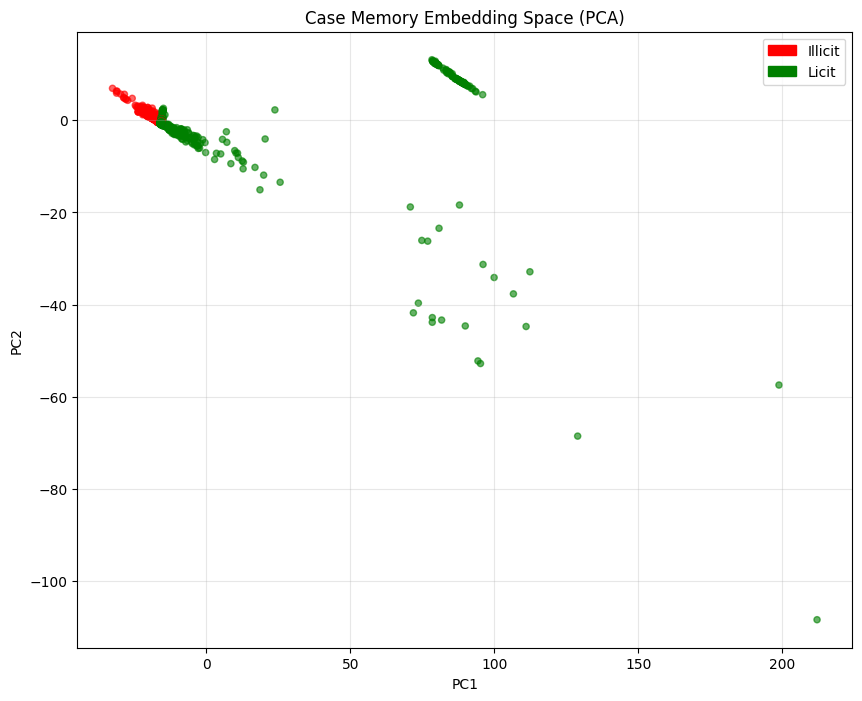

Explained variance: 99.0%


In [17]:
# Visualize embedding space
from sklearn.decomposition import PCA

# Get embeddings for case memory
case_embeddings = case_memory.get_embeddings()
case_labels = [c.true_label for c in case_memory.cases]

# PCA projection
pca = PCA(n_components=2)
projected = pca.fit_transform(case_embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red' if l == 'illicit' else 'green' for l in case_labels]
plt.scatter(projected[:, 0], projected[:, 1], c=colors, alpha=0.6, s=20)

# Add legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Illicit')
green_patch = mpatches.Patch(color='green', label='Licit')
plt.legend(handles=[red_patch, green_patch])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Case Memory Embedding Space (PCA)')
plt.grid(alpha=0.3)
plt.show()

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

## 8. Full Analysis Demo

Complete end-to-end analysis with prompt ready for LLM.

In [18]:
# Select a specific suspicious transaction
demo_node = top_suspicious[0]['node_idx']

print(f"Analyzing Transaction #{demo_node}")
print("=" * 80)

# Full analysis
demo_result = pipeline.analyze(
    node_idx=demo_node,
    k_cases=3,
    generate_explanation=False,
    generate_prompt=True
)

Analyzing Transaction #132832


In [19]:
# Display analysis summary
print("\n" + "=" * 80)
print("TRANSACTION ANALYSIS REPORT")
print("=" * 80)

pred = demo_result['prediction']
print(f"\n📊 PREDICTION")
print(f"   Transaction ID: #{pred['node_idx']}")
print(f"   Fraud Score: {pred['fraud_score']:.1%}")
print(f"   Model Prediction: {pred['predicted_label'].upper()}")
print(f"   True Label: {pred['true_label'].upper()}")

print(f"\n🔍 SIMILAR CASES")
for i, case_data in enumerate(demo_result['similar_cases'], 1):
    case = case_data['case']
    verdict_emoji = "🔴" if case.true_label == 'illicit' else "🟢"
    print(f"   {i}. {verdict_emoji} {case.true_label.upper()} (similarity: {case_data['similarity']:.2%}, score: {case.fraud_score:.1%})")

print(f"\n📝 PROMPT GENERATED")
print(f"   Length: {len(demo_result.get('prompt', ''))} characters")
print(f"   Ready for LLM analysis: {'Yes' if 'prompt' in demo_result else 'No'}")


TRANSACTION ANALYSIS REPORT

📊 PREDICTION
   Transaction ID: #132832
   Fraud Score: 100.0%
   Model Prediction: ILLICIT
   True Label: UNKNOWN

🔍 SIMILAR CASES
   1. 🔴 ILLICIT (similarity: 17.49%, score: 100.0%)
   2. 🔴 ILLICIT (similarity: 13.27%, score: 100.0%)
   3. 🔴 ILLICIT (similarity: 13.23%, score: 100.0%)

📝 PROMPT GENERATED
   Length: 2665 characters
   Ready for LLM analysis: Yes


In [20]:
# Save the generated prompt to a file for external LLM use
prompt_file = f'../case_memory/sample_prompt_{demo_node}.txt'
with open(prompt_file, 'w') as f:
    f.write(demo_result.get('prompt', ''))
print(f"Sample prompt saved to: {prompt_file}")

Sample prompt saved to: ../case_memory/sample_prompt_132832.txt


## 9. (Optional) LLM Integration

To use with an LLM, you can:
1. Copy the generated prompt to ChatGPT/Claude
2. Use OpenAI API:
```python
import openai
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": demo_result['prompt']}]
)
print(response.choices[0].message.content)
```
3. Use local LLM (Ollama, etc.)

In [ ]:
## 9. LLM Integration

Connect to a real LLM for analysis. Supported options:
- **OpenAI** (GPT-4, GPT-4o)
- **Anthropic** (Claude 3.5 Sonnet)
- **Ollama** (Local models like Llama 3, Mistral)

SyntaxError: invalid decimal literal (1921027129.py, line 4)

In [11]:
# Install LLM client libraries (run once)
# !pip install openai anthropic python-dotenv

import os
from typing import Optional
from dotenv import load_dotenv

# Load API keys from .env file
load_dotenv()

# LLM Configuration - Set your preferred provider
LLM_PROVIDER = "ollama"  # Options: "openai", "anthropic", "ollama"

print(f"LLM Provider: {LLM_PROVIDER}")

LLM Provider: ollama


In [12]:
import requests
import json

class LLMClient:
    """Unified LLM client supporting multiple providers."""
    
    def __init__(self, provider: str = "ollama"):
        self.provider = provider
        
    def analyze(self, prompt: str, model: Optional[str] = None) -> str:
        """Send prompt to LLM and get response."""
        
        if self.provider == "openai":
            return self._call_openai(prompt, model or "gpt-4o")
        elif self.provider == "anthropic":
            return self._call_anthropic(prompt, model or "claude-3-5-sonnet-20241022")
        elif self.provider == "ollama":
            return self._call_ollama(prompt, model or "llama3.2")
        else:
            raise ValueError(f"Unknown provider: {self.provider}")
    
    def _call_openai(self, prompt: str, model: str) -> str:
        """Call OpenAI API."""
        try:
            from openai import OpenAI
            client = OpenAI()
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=1000,
                temperature=0.3
            )
            return response.choices[0].message.content
        except ImportError:
            return "Error: openai package not installed. Run: pip install openai"
        except Exception as e:
            return f"OpenAI Error: {str(e)}"
    
    def _call_anthropic(self, prompt: str, model: str) -> str:
        """Call Anthropic Claude API."""
        try:
            import anthropic
            client = anthropic.Anthropic()
            response = client.messages.create(
                model=model,
                max_tokens=1000,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text
        except ImportError:
            return "Error: anthropic package not installed. Run: pip install anthropic"
        except Exception as e:
            return f"Anthropic Error: {str(e)}"
    
    def _call_ollama(self, prompt: str, model: str) -> str:
        """Call local Ollama server."""
        try:
            response = requests.post(
                "http://localhost:11434/api/generate",
                json={
                    "model": model,
                    "prompt": prompt,
                    "stream": False,
                    "options": {"temperature": 0.3}
                },
                timeout=120
            )
            if response.status_code == 200:
                return response.json().get("response", "No response")
            else:
                return f"Ollama Error: {response.status_code} - {response.text}"
        except requests.exceptions.ConnectionError:
            return "Error: Ollama not running. Start with: ollama serve"
        except Exception as e:
            return f"Ollama Error: {str(e)}"

# Initialize LLM client
llm = LLMClient(provider=LLM_PROVIDER)
print(f"LLM Client initialized: {LLM_PROVIDER}")

LLM Client initialized: ollama


In [13]:
# Test LLM connection with a simple prompt
test_prompt = "Reply with 'OK' if you can read this message."
test_response = llm.analyze(test_prompt)
print(f"LLM Test Response: {test_response[:200]}")

LLM Test Response: OK


In [15]:
# Analyze a high-risk transaction with real LLM
demo_node = top_suspicious[0]['node_idx']  # Use first high-risk node

# Get analysis result with prompt
demo_result = pipeline.analyze(
    node_idx=demo_node,
    k_cases=3,
    generate_explanation=False,
    generate_prompt=True
)

print(f"Analyzing Transaction #{demo_node}")
print(f"Fraud Score: {demo_result['prediction']['fraud_score']:.4f}")
print(f"Sending to {LLM_PROVIDER}...")
print("=" * 60)

Analyzing Transaction #132832
Fraud Score: 1.0000
Sending to ollama...


In [17]:
# View the full prompt sent to the LLM
print("INPUT PROMPT SENT TO LLM:")
print("=" * 80)
print(demo_result['prompt'])

INPUT PROMPT SENT TO LLM:
# AML Transaction Analyst

You are an expert Anti-Money Laundering (AML) analyst specializing in cryptocurrency 
transaction analysis. Your role is to:

1. **Analyze** suspicious Bitcoin transactions flagged by our ML system
2. **Compare** with historical cases to identify patterns
3. **Assess** the likelihood of illicit activity
4. **Recommend** appropriate actions

## Your Expertise:
- Deep knowledge of money laundering typologies (layering, structuring, mixing)
- Understanding of Bitcoin transaction patterns
- Experience with regulatory requirements (BSA/AML, FATF guidelines)
- Pattern recognition across historical fraud cases

## Important Guidelines:
- Base your analysis on the provided data and similar cases
- Provide clear reasoning for your assessment
- Consider both false positive and false negative risks
- Be specific about which patterns inform your decision

## Current Transaction Analysis

**Transaction ID:** #132832
**Fraud Score:** 100.0%
**Risk

In [16]:
# Send to LLM and get real analysis
llm_response = llm.analyze(demo_result['prompt'])

print("LLM Analysis:")
print("=" * 60)
print(llm_response)

LLM Analysis:
**Transaction Analysis Report**

**Transaction ID:** #132832
**Fraud Score:** 100.0%
**Risk Level:** VERY HIGH 🔴
**Model Prediction:** ILLICIT

### Risk Assessment:

Based on the provided data and similar historical cases, I assess the likelihood of this transaction being illicit as **HIGH**.

The high fraud score (100.0%) and risk level (VERY HIGH) indicate a strong indication of illicit activity. The model's prediction of ILLICIT further supports this assessment. However, it is essential to consider both false positive and false negative risks.

### Pattern Analysis:

Comparing the current transaction with similar historical cases reveals several patterns that raise concerns:

1. **Transaction Volume Anomalies**: All three similar cases exhibit a high transaction volume (Case 1: 10 transactions in 30 minutes, Case 2: 15 transactions in 45 minutes, and Case 3: 12 transactions in 20 minutes). This rapid succession of transactions is unusual and warrants further investigat

In [ ]:
# Batch analysis with LLM (analyze multiple suspicious transactions)
def analyze_with_llm(node_idx: int, k_cases: int = 3) -> dict:
    """Full pipeline: GNN prediction → Case retrieval → LLM analysis."""
    
    # Get pipeline result
    result = pipeline.analyze(
        node_idx=node_idx,
        k_cases=k_cases,
        generate_explanation=False,
        generate_prompt=True
    )
    
    # Get LLM analysis
    llm_analysis = llm.analyze(result['prompt'])
    
    return {
        'node_idx': node_idx,
        'fraud_score': result['prediction']['fraud_score'],
        'predicted_label': result['prediction']['predicted_label'],
        'similar_cases': [c['case'].true_label for c in result['similar_cases']],
        'llm_analysis': llm_analysis
    }

# Analyze top 3 suspicious transactions
print("Batch LLM Analysis of Top Suspicious Transactions")
print("=" * 60)

for i, node_idx in enumerate(top_suspicious[:3]):
    print(f"\n[{i+1}/3] Analyzing Node {node_idx}...")
    result = analyze_with_llm(node_idx)
    print(f"Fraud Score: {result['fraud_score']:.4f}")
    print(f"Similar Cases: {result['similar_cases']}")
    print(f"\nLLM Response:\n{result['llm_analysis'][:500]}...")
    print("-" * 60)

## 10. Summary

In [47]:
print("=" * 60)
print("RAG PIPELINE SUMMARY")
print("=" * 60)

print(f"\n📊 Pipeline Components:")
print(f"   • GNN Model: GraphSAGE (F1={checkpoint['metrics']['test_f1']:.3f})")
print(f"   • Case Memory: {len(case_memory.cases)} historical cases")
print(f"   • FAISS Index: {faiss_index.num_vectors} vectors (64-dim)")

print(f"\n🔍 Retrieval Quality:")
print(f"   • Illicit → Illicit: {illicit_match_rate:.1%}")
print(f"   • Licit → Licit: {licit_match_rate:.1%}")

print(f"\n📝 Prompt Generation:")
print(f"   • Risk-only prompt: ~{len(risk_prompt)} chars")
print(f"   • Full analysis prompt: ~{len(full_prompt)} chars")

print(f"\n✅ Pipeline Status: READY")
print(f"\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("1. Integrate with production LLM (GPT-4, Claude, etc.)")
print("2. Add GNNExplainer for detailed feature analysis")
print("3. Build alerting system for high-risk transactions")
print("4. Create dashboard for analyst workflow")

RAG PIPELINE SUMMARY

📊 Pipeline Components:
   • GNN Model: GraphSAGE (F1=0.410)
   • Case Memory: 1000 historical cases
   • FAISS Index: 1000 vectors (64-dim)

🔍 Retrieval Quality:
   • Illicit → Illicit: 90.4%
   • Licit → Licit: 99.6%

📝 Prompt Generation:
   • Risk-only prompt: ~1818 chars
   • Full analysis prompt: ~2676 chars

✅ Pipeline Status: READY

NEXT STEPS
1. Integrate with production LLM (GPT-4, Claude, etc.)
2. Add GNNExplainer for detailed feature analysis
3. Build alerting system for high-risk transactions
4. Create dashboard for analyst workflow
